In [1]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [2]:
%matplotlib inline

# Image segmentation

In this notebook, we work with the CAMVID dataset, which as we'll see below consists of traffic images from a car camera - the stuff any self-driving car would be processing as inputs. The task we're interested in here would be image segmentation. This could be framed as a classification problem for every pixel in an image as to what "segment" or object that pixel belongs to.

### obtaining the data 

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[WindowsPath('C:/Users/htngu/.fastai/data/camvid/codes.txt'),
 WindowsPath('C:/Users/htngu/.fastai/data/camvid/images'),
 WindowsPath('C:/Users/htngu/.fastai/data/camvid/labels'),
 WindowsPath('C:/Users/htngu/.fastai/data/camvid/valid.txt')]

In [4]:
path_labels = path/'labels'
path_images = path/'images'

### subclasses 

In [5]:
#path = Path('./data/camvid-small')

def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

In [6]:

src = (SegmentationItemList.from_folder(path)
        .split_by_folder(valid='val')
        .label_from_func(get_y_fn, classes=codes))

bs=16
data = (src.transform(get_transforms(), tfm_y=True)
         .databunch(bs=bs)
         .normalize(imagenet_stats))

C:\Users\htngu\Anaconda3\envs\kaggle_pandas\lib\site-packages\fastai\data_block.py:454: UserWarning: Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.")
C:\Users\htngu\Anaconda3\envs\kaggle_pandas\lib\site-packages\fastai\data_block.py:457: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


### Data

Let's look at a sample image

In [7]:
fnames = get_image_files(path_images); fnames[:2]

[WindowsPath('C:/Users/htngu/.fastai/data/camvid/images/0001TP_006690.png'),
 WindowsPath('C:/Users/htngu/.fastai/data/camvid/images/0001TP_006720.png')]

In [8]:
label_names = get_image_files(path_labels)

We can use open_image(path) from fastai to open an image, like so

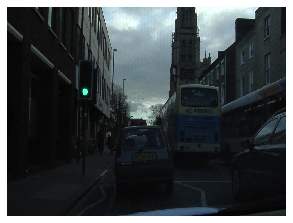

In [9]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

Now, this image doesn't show the 'labels' yet. We can visualize this using the open_mask function, like so:

In [10]:
label_names[0]

WindowsPath('C:/Users/htngu/.fastai/data/camvid/labels/0001TP_006690_P.png')

In [11]:
get_y_fn = lambda x: path_labels/f'{x.stem}_P{x.suffix}'

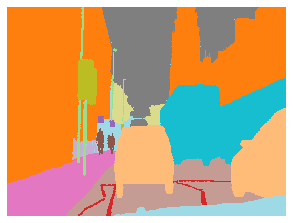

In [12]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [13]:
mask.shape

torch.Size([1, 720, 960])

In [14]:
mask.data

tensor([[[ 4,  4,  4,  ...,  4,  4,  4],
         [ 4,  4,  4,  ...,  4,  4,  4],
         [ 4,  4,  4,  ...,  4,  4,  4],
         ...,
         [19, 19, 19,  ..., 30, 30, 30],
         [19, 19, 19,  ..., 30, 30, 30],
         [19, 19, 19,  ..., 30, 30, 30]]])

In [15]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

We see for example that pixels with label 4 are associated with 'Building', which here has the colour orange.

# Dataset 

In [16]:
img_size = np.array([720,960])
size = img_size//2

In [17]:
gpu_mem_get_free_no_cache()

5878

Apparently for modest RAM available on GPU, we work with small batches. Fair enough. The batchsize is small because we're classifying every pixel in an image - which is a lot.

In [18]:
bs = 6

In [19]:
src = (SegmentationItemList.from_folder(path_images)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes)
      )

In [20]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats)
       )

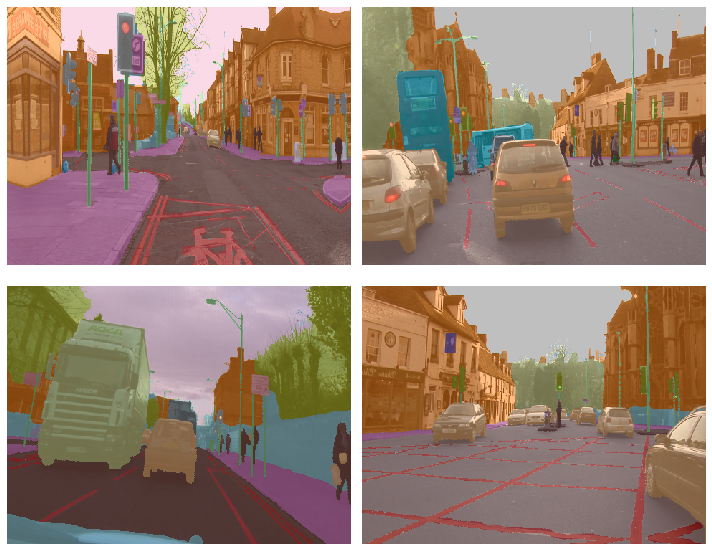

In [21]:
data.show_batch(2, figsize=(10,8))

We note that since these images are camera frames, we shouldn't really split train/validation randomly as close-by images in time are essentially too similar and may allow the model to cheat. Instead, the dataset reserves a separate validation set, presumably from a different time.

In [22]:
data.valid_dl.__len__()

17

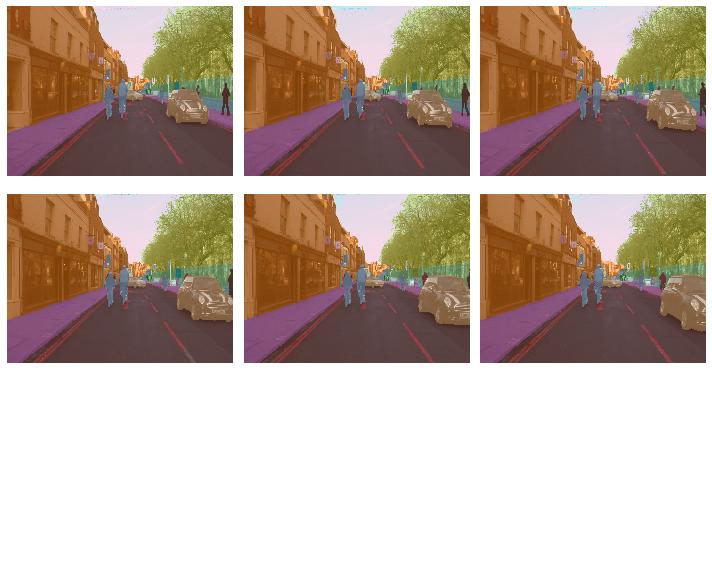

In [23]:
data.show_batch(3, figsize=(10,8), ds_type=DatasetType.Valid)

# Model - UNET for segmentation 

In [24]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

In [25]:
def acc_camvid(predict, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (predict.argmax(dim=1)[mask]==target[mask]).float().mean()

In [26]:
metrics = acc_camvid

The metric basically computes pixel-level prediction accuracy. 

In [27]:
wd=1e-2

Note here that we can use mixed-precision training to lighten the memory load, while not necessarily decreasing performance. Funnily enough, Jeremy found the mixed-prec model to perform slightly better here. Who knew?

In [28]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd).to_fp16()

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


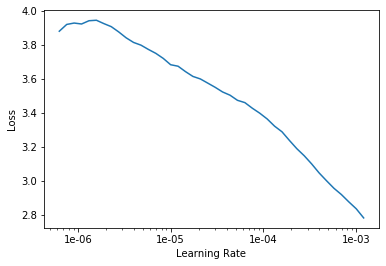

In [29]:
lr_find(learn); learn.recorder.plot()

In [30]:
lr = 1e-4

In [31]:
slice(lr)

slice(None, 0.0001, None)

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,2.489547,1.910084,0.547388,04:25
1,1.474440,1.179119,0.729663,04:25
2,1.029086,0.844494,0.810101,04:19
3,0.810599,0.667187,0.830561,04:21
4,0.697079,0.630463,0.831761,04:20
5,0.639138,0.677747,0.822716,04:20
6,0.582111,0.483077,0.861324,04:18


In [33]:
learn.save('stage-1-unet-resnet34-fp16')

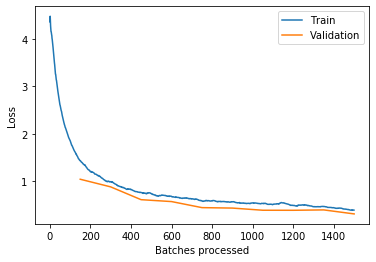

In [54]:
learn.recorder.plot_losses()

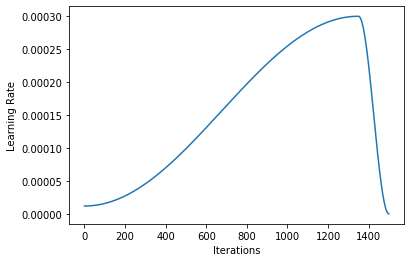

In [55]:
learn.recorder.plot_lr()

In [17]:
learn.load('stage-1-unet-resnet34')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: C:\Users\htngu\.fastai\data\camvid\images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: C:\Users\htngu\.fastai\data\camvid\images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [18]:
learn.unfreeze()

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


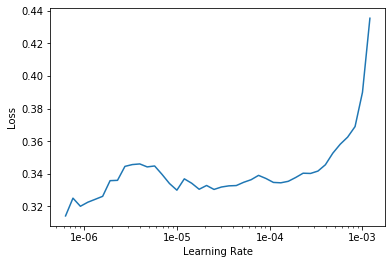

In [19]:
learn.lr_find(); learn.recorder.plot()

In [20]:
learn.fit_one_cycle(12, slice(1e-5, 1e-4), pct_start=.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.342302,0.294522,0.914640,03:01
1,0.338687,0.291724,0.914491,03:04
2,0.327649,0.297068,0.913207,03:03
3,0.324360,0.291587,0.916881,03:06
4,0.316977,0.289233,0.916509,03:07
5,0.309872,0.276067,0.919653,03:09
6,0.310328,0.289755,0.916339,03:02
7,0.304960,0.309813,0.906205,03:01
8,0.301617,0.313542,0.908777,03:00
9,0.282245,0.319016,0.907240,03:02


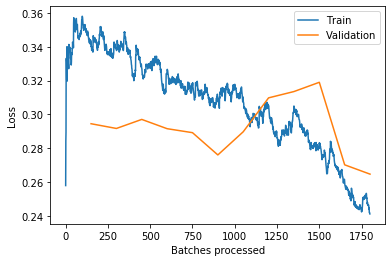

In [22]:
learn.recorder.plot_losses()

In [21]:
learn.save('stage-2-unet-resnet34')

## go big or go home

In [23]:
learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


In [24]:
size = img_size
bs = 1

In [25]:

data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [26]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [27]:
learn.load('stage-2-unet-resnet34')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: C:\Users\htngu\.fastai\data\camvid\images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: C:\Users\htngu\.fastai\data\camvid\images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


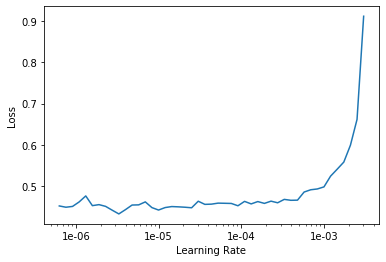

In [28]:
lr_find(learn); learn.recorder.plot()

In [29]:
lr = 3e-4

In [30]:
learn.fit_one_cycle(10, slice(lr), pct_start=.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.371110,0.270398,0.922003,07:52
1,0.342295,0.310743,0.913886,07:54
2,0.344181,0.291499,0.915431,07:55
3,0.357003,0.395002,0.894775,07:54
4,0.415618,0.391879,0.884664,07:53
5,0.383850,0.269066,0.930479,07:52
6,0.363814,0.353688,0.903541,07:52
7,0.324471,0.311676,0.916337,07:52
8,0.284065,0.301557,0.913953,07:52
9,0.218019,0.247647,0.928255,07:53


In [31]:
learn.save('stage-1-unet-resnet34-big')

In [37]:
learn.load('stage-1-unet-resnet34-big')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: C:\Users\htngu\.fastai\data\camvid\images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: C:\Users\htngu\.fastai\data\camvid\images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [38]:
learn.unfreeze()

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


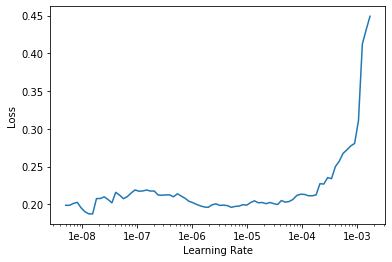

In [39]:
learn.lr_find(1e-9, 1e-2); learn.recorder.plot()

In [40]:
learn.fit_one_cycle(10, slice(1e-6, 3e-5), pct_start=.5)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.218314,0.257344,0.926016,08:07
1,0.218675,0.258702,0.925098,08:16
2,0.207635,0.270467,0.922765,08:20
3,0.203131,0.260264,0.925148,08:09
4,0.201423,0.265191,0.926515,08:12
5,0.203465,0.254920,0.928309,08:13
6,0.189329,0.261514,0.926867,08:14
7,0.186303,0.255039,0.927985,08:14
8,0.179458,0.268999,0.925917,08:14
9,0.178572,0.270301,0.924433,08:14


Can't improve performance like in the lesson :( , train loss does decrease but that doesn't seem to carry on to the validation set. Not sure where the learning rates the lesson used are from.